# DATA 3010 - Final Project
#### Freyja Kristjanson & Caitlin Kostna

In [1]:
import time
start_time = time.time() # total project execution time is stated at the end of the notebook

# Overview

<font color='red'>**NOTE:** We are assuming that this notebook is in the same directory as the dataset we are using.</font>

Our goal is to create an effective model that can correctly classify the type of chocolate - either dark or white - from a given image.

This is a supervised and offline/batch learning problem because the training set that we will feed to our algorithms includes our desired solutions, and our models are trained with the data we have and won't learn anything further when given new data.

The main performance metrics we plan to use to evaluate our models include:
 - accuracy 
 - log loss 

but we are also looking at:
 - precision
 - recall
 - F1-score
 - cross-validation scores
 - precision-recall curve & score
 - area under the curve (AUC)
 - confusion matrix

The minimum performance to determine if our final model is effective is 90% in accuracy. 

Lastly, it is important to note that we are assuming that any images being passed to our model strictly include dark chocolate or white chocolate.

# Setup

Before we get started, we will load any necessary packages.

In [2]:
import os
import pathlib
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

from PIL import Image
from numpy import asarray

import tensorflow as tf
from tensorflow import keras
from itertools import cycle

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import distance_metrics

First, we will set the random state that will be used throughout the project for reproducibility, and specify the two target names of our dataset. 

In [3]:
random_state = 22
target_names = ['Dark Chocolate', 'White Chocolate']

We have created a variety of functions to help automate some of the processes we will be using multiple times. 

**load_data:** Loads the images in our dataset which are stored in a directory.

It walks through the main directory `chocolate_photos` going into the two subdirectories `Dark Chocolate` and `White Chocolate`. These directory names are the target values. Each image is converted into an `np.array` and stored into the `X` variable. Since the images are all of different sizes, we resize them to be `(256, 256)` for consistency. Depending on where the image is located, the appropriate target value is saved in the `y` variable. 

In [4]:
def load_data(path):
    data_dir = pathlib.Path(path)
    image_count = len(list(data_dir.glob('*/*.jpg'))) # number of images that are .jpg's 

    X = []
    y = np.empty(image_count, dtype = int)
    i = 0
    for path, subdirs, files in os.walk(data_dir):
        for name in files:
            if not name.startswith("."): # ignore hidden files 
                img_path = os.path.join(path, name)
                if img_path.startswith("chocolate_photos/Dark Chocolate"):
                    y[i] = 0
                if img_path.startswith("chocolate_photos/White Chocolate"):
                    y[i] = 1
                X.append(asarray((Image.open(img_path).resize((256, 256)))))
                i = i + 1
    X = np.array(X, dtype = object)
    
    return X, y

**split_data:** Performs `train_test_split` on our `x` and `y` data using the specified split value. 

We are creating three sets: training, validation, and testing. This means we first split the data into the training and the remaining data, and then take the remaining and split that up into validation and test. The parameter `train_split` specifies what proportion of the entire dataset the training set is. Since we want the splits to reflect the ratio of dark to white chocolate that appears in the original dataset, we are splitting (`stratify`) using the target values. We are choosing to split the validation and test sets exactly in half, but the proportions are set to stay the same. We return all 6 sets. 

In [5]:
def split_data(X, y, train_split):
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = train_split, 
                                                           stratify = y, random_state = random_state)

    X_valid, X_test, y_valid, y_test = train_test_split(
        X_rem, y_rem, test_size = 0.5, stratify = y_rem, random_state = random_state)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

**scale_data:** Reshapes the images so that the models can use the data and standardizes `X_train`, `X_valid`, and `X_test` using `StandardScalar()`. 

First we find how many images are in each dataset, this comes from the `.shape[0]`, then we reshape the data to be `256*256*3` because each image is 256 x 256 pixels with an rgb (3) format. Next we fit the training data with `StandardScalar` and transform the `X` sets. Lastly we return the scaled versions of `X_train`, `X_valid`, and `X_test`. 

In [6]:
def scale_data(X_train_base, X_valid_base, X_test_base):
    train_length = X_train_base.shape[0]
    val_length = X_valid_base.shape[0]
    test_length = X_test_base.shape[0]

    X_train_reshaped = (X_train_base.reshape(train_length, 256*256*3))
    X_valid_reshaped = X_valid_base.reshape(val_length, 256*256*3)
    X_test_reshaped = X_test_base.reshape(test_length, 256*256*3)

    scaler = preprocessing.StandardScaler().fit(X_train_reshaped)
    X_train = scaler.transform(X_train_reshaped)
    X_valid = scaler.transform(X_valid_reshaped)
    X_test = scaler.transform(X_test_reshaped)
    
    return X_train, X_valid, X_test

**performance_metrics:** calculates and prints the specified performance metrics in a table given the model's prediction

In [7]:
def performance_metrics(prediction, model_type = "Model", validation = True):
    if validation:
        print('\033[1m' + "Validation Scores" + '\033[0m')
        y = y_valid
    else:
        print('\033[1m' + "Test Scores" + '\033[0m')
        y = y_test
        
    acc = metrics.accuracy_score(y, prediction)
    loss = metrics.log_loss(y, prediction)
        
    print('\033[1m' + model_type + '\033[0m')
    print(" Accuracy:  {:3.2%}".format(acc))
    print(" Log Loss:  {:3.2%}".format(loss))
    print(" Precision: {:3.2%}".format(metrics.precision_score(y, prediction)))
    print(" Recall:    {:3.2%}".format(metrics.recall_score(y, prediction)))
    print(" F1:        {:3.2%}".format(metrics.f1_score(y, prediction)))
    print(" ROC-AUC:   {:3.2%}".format(metrics.roc_auc_score(y, prediction)))
    
    return acc, loss  

**display_accuracies:** Prints the accuracy and log loss of models in a table.

In [8]:
def display_accuracies(accuracies, losses, model_names):
    df = {'Accuracy': accuracies, 'Log Loss': losses}
    df = pd.DataFrame(data = df, index = model_names)
    df = df.sort_values(by = "Accuracy", ascending = False)
    df = df.style.format({'Accuracy': "{:3.2%}", 'Log Loss': "{:3.2%}"})
    display(df)

**plot_roc_auc:** Plots the ROC curve with the area under curve value given the model probabilities from validation.

In [9]:
def plot_roc_auc(model_proba):
    fpr, tpr, _ = metrics.roc_curve(y_valid,  model_proba)
    auc = metrics.roc_auc_score(y_valid, model_proba)

    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

**plot_model_metrics:** Plots the model accuracy and model loss curves from a neural network history object.

In [10]:
def plot_model_metrics(model_history):
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

**display_best_splits:** Prints the best `train_test_split` for each model based on accuracy in a table.

In [11]:
def display_best_splits(splits, log_reg_accuracies, gnb_accuracies, svm_accuracies, knn_accuracies, 
                       dt_accuracies, rf_accuracies):

    best_log_split = splits[log_reg_accuracies.index(max(log_reg_accuracies))]
    best_nb_split = splits[gnb_accuracies.index(max(gnb_accuracies))]
    best_svm_split = splits[svm_accuracies.index(max(svm_accuracies))]
    best_knn_split = splits[knn_accuracies.index(max(knn_accuracies))]
    best_dt_split = splits[dt_accuracies.index(max(dt_accuracies))]
    best_rf_split = splits[rf_accuracies.index(max(rf_accuracies))]
    
    best_splits = [best_log_split, best_nb_split, best_svm_split, best_knn_split, best_dt_split, best_rf_split]
    accuracies = [max(log_reg_accuracies), max(gnb_accuracies), max(svm_accuracies), 
                  max(knn_accuracies), max(dt_accuracies), max(rf_accuracies)]
    model_names = ["Logistic Regression", "Naive Bayes", "Support Vector", 
                   "Nearest Neighbour", "Decision Tree", "Random Forest"]
    
    df = {'Split': best_splits, 'Accuracy': accuracies}
    df = pd.DataFrame(data = df, index = model_names)
    df = df.sort_values(by = "Accuracy", ascending = False)
    df = df.style.format({'Split': "{:.2}", 'Accuracy': "{:3.2%}"})
    display(df)

**find_best_split:** Performs multiple splits of data and model training to find the split value that gives the highest model accuracy. Uses `display_best_splits`.

The parameter `splits` is a list of float values between (0, 1) that the dataset should be split by. For each split the 6 base models we are exploring (Logistic Regression, Naive Bayes, Support Vector Machine, K-Nearest Neighbours, Decision Tree, and Random Forest) are all fitted and used to predict the validation data. The training scores are calculated using `cross_val_score`, and the difference between training and validation accuracy is also calculated. Real time information is displayed as well as the final results of the best splits for each model (based on their validation score).  

In [12]:
def find_best_split(splits):
    
    log_reg_accuracies = []
    gnb_accuracies = []
    svm_accuracies = []
    knn_accuracies = []
    dt_accuracies = []
    rf_accuracies = []
    
    start = time.time()
    for split in splits:
        print("Training Size = {}".format(split))
    
        X_train_base, y_train, X_valid_base, y_valid, X_test_base, y_test = split_data(X, y, split)
        X_train, X_valid, X_test = scale_data(X_train_base, X_valid_base, X_test_base)
        
        log_reg = LogisticRegression(random_state = random_state)
        log_reg.fit(X_train, y_train)
        scores = cross_val_score(log_reg, X_train, y_train, scoring = 'accuracy')
        log_acc = scores.mean()
        val_score = metrics.accuracy_score(y_valid, log_reg.predict(X_valid))
        log_reg_accuracies.append(val_score)
        diff = log_acc - val_score
        print("  Logistic Regression       Training={:3.2%}  Validation={:3.2%}  Difference= {:3.2%}"
              .format(log_acc, val_score, diff))

        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        scores = cross_val_score(gnb, X_train, y_train, scoring = 'accuracy')
        gnb_acc = scores.mean()
        val_score = metrics.accuracy_score(y_valid, gnb.predict(X_valid))
        gnb_accuracies.append(val_score)
        diff = gnb_acc - val_score
        print("  Naive Bayes               Training={:3.2%}  Validation={:3.2%}  Difference= {:3.2%}"
              .format(gnb_acc, val_score, diff))

        svm = SVC(random_state = random_state)
        svm.fit(X_train, y_train)
        scores = cross_val_score(svm, X_train, y_train, scoring = 'accuracy')
        svm_acc = scores.mean()
        val_score = metrics.accuracy_score(y_valid, svm.predict(X_valid))
        svm_accuracies.append(val_score)
        diff = svm_acc - val_score
        print("  Support Vector Machines   Training={:3.2%}  Validation={:3.2%}  Difference= {:3.2%}"
              .format(svm_acc, val_score, diff))

        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        scores = cross_val_score(knn, X_train, y_train, scoring = 'accuracy')
        knn_acc = scores.mean()
        val_score = metrics.accuracy_score(y_valid, knn.predict(X_valid))
        knn_accuracies.append(val_score)
        diff = knn_acc - val_score
        print("  K-Nearest Neighbour       Training={:3.2%}  Validation={:3.2%}  Difference= {:3.2%}"
              .format(knn_acc, val_score, diff))

        dt = DecisionTreeClassifier(random_state = random_state)
        dt.fit(X_train, y_train)
        scores = cross_val_score(dt, X_train, y_train, scoring = 'accuracy')
        dt_acc = scores.mean()
        val_score = metrics.accuracy_score(y_valid, dt.predict(X_valid))
        dt_accuracies.append(val_score)
        diff = dt_acc - val_score
        print("  Descision Tree            Training={:3.2%}  Validation={:3.2%}  Difference= {:3.2%}"
              .format(dt_acc, val_score, diff))

        rf = RandomForestClassifier(random_state = random_state)
        rf.fit(X_train, y_train)
        scores = cross_val_score(rf, X_train, y_train, scoring = 'accuracy')
        rf_acc = scores.mean()
        val_score = metrics.accuracy_score(y_valid, rf.predict(X_valid))
        rf_accuracies.append(val_score)
        diff = rf_acc - val_score
        print("  Random Forest             Training={:3.2%}  Validation={:3.2%}  Difference= {:3.2%}"
              .format(rf_acc, val_score, diff))
    
    display_best_splits(splits, log_reg_accuracies, gnb_accuracies, svm_accuracies, 
                       knn_accuracies, dt_accuracies, rf_accuracies)
    print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

**grid_search_results:** Prints the details about the outcome of a grid search. 

Prints the best parameters, the best estimator, and the best accuracy score. 

In [13]:
def grid_search_results(grid_search):
    print("Best Parameters:", grid_search.best_params_)
    print("Best Estimator: ", grid_search.best_estimator_)
    print("Best Accuracy:  ", grid_search.best_score_)

# Get the Data   

The dataset we are exploring features images of chocolate. It is from **Kaggle**, and from the metadata provided, the images were taken from **Bing**, via web scraping using the *Bing Image Downloader*. Below is a link to the dataset:

https://www.kaggle.com/datasets/siddharthmandgi/chocolate-classification

The original dataset had 137 images. However, after downloading, we had to clean up and convert some of the images to a usable format. Unfortunately, we lost a few images as they wouldn't convert. Now, combined, there are 133 full coloured images of chocolate. There are 67 images of dark chocolate, and 66 images of white chocolate. Most are chocolate bars, but there are several chocolatey treats as well. Of the chocolate bars, it appears to be a collection of various brands. Some have writing, such as the packaging or watermarks.

We load and save the input and target values in `X` and `y`. 

In [14]:
X, y = load_data("chocolate_photos")

# Explore the data  

To get an idea of what our dataset looks like, we printed a random sample of images below. 

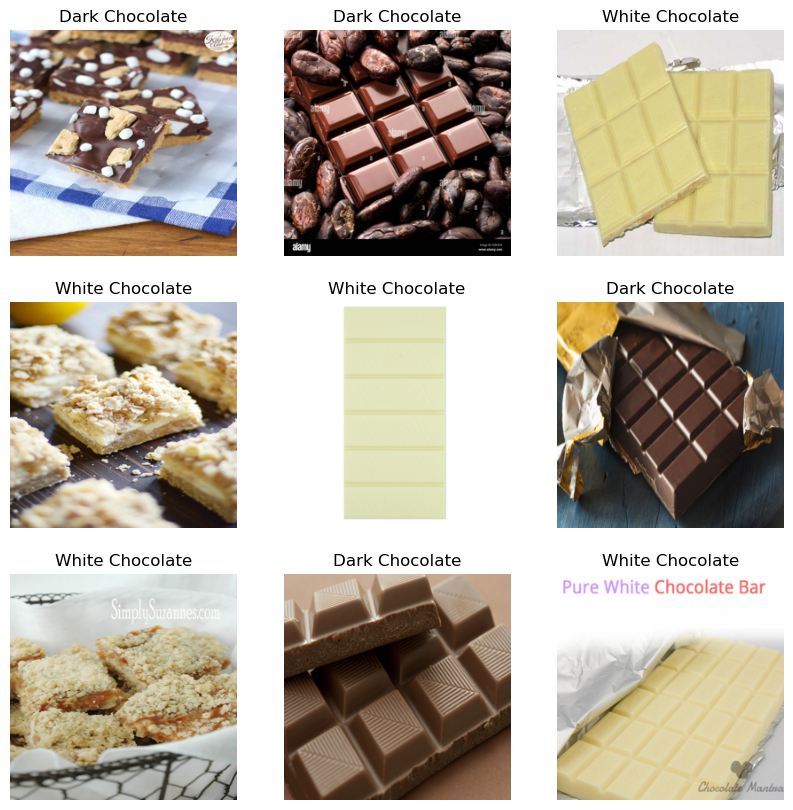

In [15]:
random.seed(72)
selection = random.sample(range(0, X.shape[0]), 9)
plt.figure(figsize = (10, 10))
i = 0
for index in selection:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(Image.fromarray((X[index]).astype(np.uint8)))
    plt.title(target_names[y[index]])
    plt.axis("off")
    i = i + 1

As you can see, we have a variety of images of chocolate. Some are plain chocolate bars, while some are baked goods or have other sweets on top.

Next, we wanted to get a sense of the numerical representation of our data. Since the feature space is so big `(256*256*3)` we used `PCA` to transform the data down into 2 dimensions for visualization. 

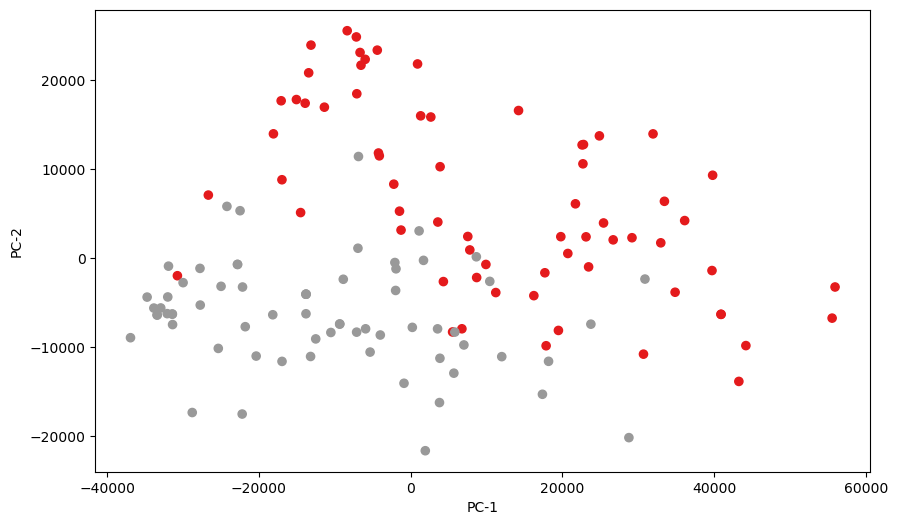

In [16]:
X_scaled = X.reshape(X.shape[0], 256*256*3) # use full dataset
pca = PCA(2) # use 2 principal components
converted_data = pca.fit_transform(X_scaled)

plt.figure(figsize = (10, 6))
c_map = plt.cm.get_cmap('Set1', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 35,
            cmap = c_map , c = y)
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

The PCA scatterplot above shows that our dataset is quite spread out with no real distinction between classes. Most of the grey points are lower and most of the red points are above, but there is considerable overlap. 

# Prepare the data  

First we will look at the results of various `train_test` splits. 

In [17]:
splits = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9]
find_best_split(splits)

Training Size = 0.4
  Logistic Regression       Training=94.18%  Validation=87.50%  Difference= 6.68%
  Naive Bayes               Training=88.55%  Validation=87.50%  Difference= 1.05%
  Support Vector Machines   Training=94.36%  Validation=87.50%  Difference= 6.86%
  K-Nearest Neighbour       Training=79.45%  Validation=82.50%  Difference= -3.05%
  Descision Tree            Training=81.45%  Validation=82.50%  Difference= -1.05%
  Random Forest             Training=86.73%  Validation=82.50%  Difference= 4.23%
Training Size = 0.45
  Logistic Regression       Training=93.18%  Validation=89.19%  Difference= 3.99%
  Naive Bayes               Training=87.73%  Validation=89.19%  Difference= -1.46%
  Support Vector Machines   Training=91.21%  Validation=89.19%  Difference= 2.02%
  K-Nearest Neighbour       Training=80.00%  Validation=89.19%  Difference= -9.19%
  Descision Tree            Training=76.36%  Validation=89.19%  Difference= -12.83%
  Random Forest             Training=93.18%  Valida

,Split,Accuracy
Logistic Regression,0.9,100.00%
Naive Bayes,0.9,100.00%
Support Vector,0.9,100.00%
Random Forest,0.9,100.00%
Nearest Neighbour,0.45,89.19%
Decision Tree,0.45,89.19%



Total Execution Time: 00:04:31


The table printed above shows the split that gives the highest validation accuracy for each model. While 0.9 is the best for four of the models, the other two are quite low, and the differences between the training and validation accuracies are quite large. To determine the best split, we want to ensure all our basic models have the chance to perform at their best. So, we want the accuracy for training and validation to be as high as possible and their difference to be minimal across all models. For this reason, we will choose the split of 0.65.

Now we can split the data into training, validation, and testing sets using our best split value of 0.65. 

In [18]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(X, y, 0.65)

Here we show the shape (size) of each of the sets. 

In [19]:
train_length = X_train.shape[0]
val_length = X_valid.shape[0]
test_length = X_test.shape[0]

print("  Training ==> X:", X_train.shape, "Y:", y_train.shape)
print("Validation ==> X:", X_valid.shape, "Y:", y_valid.shape)
print("      Test ==> X:", X_test.shape, "Y:", y_test.shape)

  Training ==> X: (86, 256, 256, 3) Y: (86,)
Validation ==> X: (23, 256, 256, 3) Y: (23,)
      Test ==> X: (24, 256, 256, 3) Y: (24,)


Print the percentages of dark chocolate in each set to ensure that it is relatively equal across the board. 

In [20]:
print("Percentage of Dark Chocolate in Training:   {:3.2%}".format(np.count_nonzero(y_train == 1)/train_length))
print("Percentage of Dark Chocolate in Validation: {:3.2%}".format(np.count_nonzero(y_valid == 1)/val_length))
print("Percentage of Dark Chocolate in Testing:    {:3.2%}".format(np.count_nonzero(y_test == 1)/test_length))

Percentage of Dark Chocolate in Training:   50.00%
Percentage of Dark Chocolate in Validation: 47.83%
Percentage of Dark Chocolate in Testing:    50.00%


Since our dataset is quite small, we will perform transformations on our images to create new ones that are slightly different. These transformed images will be used for training only, to expose our models to a wide variety of chocolate images. To perform the transformations, we will use the `ImageDataGenerator` from `Keras` and apply the following:
   - width shift
   - height shift
   - horizontal flip
   - rotation
   - brightness (either making the image darker or brighter)
   - zoom (either zooming close to the image or moving further away)

Below is our `ImageDataGenerator` with various parameters to augment the images in our training set.

In [21]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=50,
                             brightness_range=[0.10,1.5],
                             zoom_range=[5,0.5])

Now, we can use our `datagen` function to augment all images in our training set. The output of `datagen.flow` is two `numpy` arrays; X_batch and y_batch. 

In [22]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = (X_train.shape[0]), shuffle=False,):
    break

Since we want to add our augmented photos to our training data, we will concatenate the two `numpy` arrays.

In [23]:
X_train_aug = np.concatenate((X_train, X_batch))

In [24]:
y_train_aug = np.concatenate((y_train, y_batch))

Checking the shape of the new arrays, we can see that we doubled the size of our training data.

In [25]:
X_train_aug.shape

(172, 256, 256, 3)

In [26]:
y_train_aug.shape

(172,)

Now, we can scale our data so it is usable in our models. 

In [27]:
X_train_scaled, X_valid_scaled, X_test_scaled = scale_data(X_train_aug, X_valid, X_test)

**NOTE:** only our Convolutional Neural Network won't use the augmented or scaled data as it performs augmentation during model fitting.

# Short-list Promising Models  

There are several models that can be used for binary classification. We will first train several using standard parameters, and then measure and compare their performance. These include:
- Logistic Regression
- Naïve Bayes
- K-Nearest Neighbours (KNN)
- Support Vector Machines (SVM)
- Decision Trees
- Random Forest

Once we have a short-list of promising models, we will fine-tune the hyperparameters using cross-validation. 

__NOTE:__ since there is no standard or base neural network, we will create a Convolutional Neural Network when we fine-tune our short-list of models.

For each model, we will:
 - instantiate model using default parameters
 - fit the model with our training data
 - use the validation set to run a prediction on the model
 - show the performance metrics and total execution time
 - plot the ROC curve with the area under the curve
 
## Logistic Regression

For logistic regression, we expect it will perform fairly well, but likely not the best. It is often used as a baseline model, and is good for binary classifications, as long as the linear relationship assumption holds (which based on the PCA scatterplot, is not clear). 

Validation Scores
Logistic Regression
 Accuracy:  78.26%
 Log Loss:  750.86%
 Precision: 71.43%
 Recall:    90.91%
 F1:        80.00%
 ROC-AUC:   78.79%


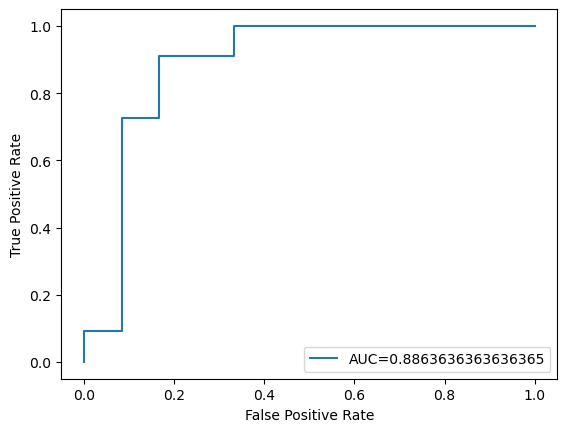


Total Execution Time: 00:00:17


In [28]:
start = time.time()

log_reg = LogisticRegression(random_state = random_state, max_iter = 1000)
log_reg.fit(X_train_scaled, y_train_aug)
log_reg_pred = log_reg.predict(X_valid_scaled)
log_reg_proba = log_reg.predict_proba(X_valid_scaled)[::,1]
log_reg_acc, log_reg_loss = performance_metrics(log_reg_pred, model_type = "Logistic Regression")

plot_roc_auc(log_reg_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Unsurprisingly, we get a validation accuracy of 78.26%. Our precision is low, recall is high at 90.91%, and F1-score is in the middle. We can see in the plot that our ROC curve has a decent area under it of 0.886. It will be interesting to see how tuning will impact its performance.

## Naïve Bayes

For Naïve Bayes, we don't have very high expectations. It is known to be not biased by outliers and works on non-linear problems, but it is based on the assumption that the features all have the same statistical relevance, which likely isn’t the case with our dataset (certain pixels in the image have more or less importance in determining dark or white chocolate).

Validation Scores
Naive Bayes
 Accuracy:  73.91%
 Log Loss:  901.03%
 Precision: 66.67%
 Recall:    90.91%
 F1:        76.92%
 ROC-AUC:   74.62%


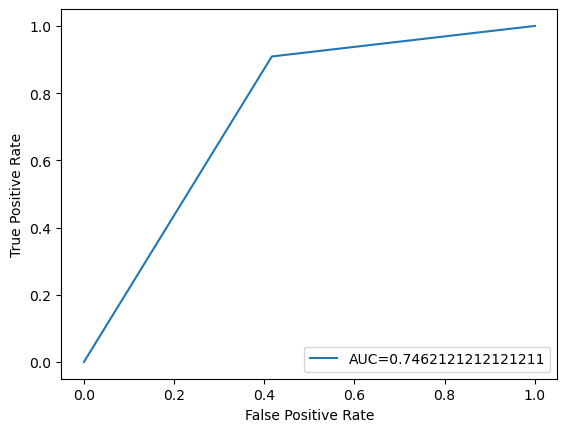


Total Execution Time: 00:00:00


In [29]:
start = time.time()

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_aug)
gnb_pred = gnb.predict(X_valid_scaled)
gnb_proba = gnb.predict_proba(X_valid_scaled)[::,1]
gnb_acc, gnb_loss = performance_metrics(gnb_pred, model_type = "Naive Bayes")

plot_roc_auc(gnb_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Just as we suspected, our model didn't perform very well. Our validation accuracy is only 73.91% with precision just under 70%. The area under our ROC curve isn't high either, at only 0.746. As a result, we won't be fine-tuning this model as it doesn't meet the minimum accuracy of 80%. 

## Support Vector Machines (SVM)

For Support Vector Machines, we aren’t expecting it to be the best or the worst. Since SVM’s are effective in cases when the number of dimensions is greater than the number of samples (as our data is), we think it might be a good choice. There is an issue of overfitting, so choosing a kernel function and regularization term during hyperparameter tuning will be important. 

Validation Scores
Support Vector Machine
 Accuracy:  91.30%
 Log Loss:  300.34%
 Precision: 84.62%
 Recall:    100.00%
 F1:        91.67%
 ROC-AUC:   91.67%


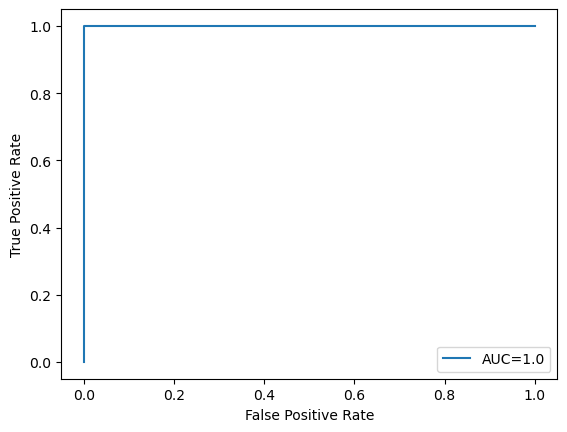


Total Execution Time: 00:00:10


In [30]:
start = time.time()

svm = SVC(probability = True, random_state = random_state)
svm.fit(X_train_scaled, y_train_aug)
svm_pred = svm.predict(X_valid_scaled)
svm_proba = svm.predict_proba(X_valid_scaled)[::,1]
svm_acc, svm_loss = performance_metrics(svm_pred, model_type = "Support Vector Machine")

plot_roc_auc(svm_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Our base SVM model performs quite well, with a validation accuracy of 91.30%. Precision is decent at 84.62% and recall is 100%. The area under our ROC curve is perfect at 1. So far, this model looks the most promising at classifying our images correctly.

## K-Nearest Neighbours (KNN)

For K-Nearest Neighbours, we expect it will perform fairly well, as it is non-linear and compares the closest images when classifying. Hyperparameter tuning and choosing the number of neighbours will likely be helpful in improving this model. 

Validation Scores
K-Nearest Neighbours
 Accuracy:  60.87%
 Log Loss:  1351.55%
 Precision: 55.00%
 Recall:    100.00%
 F1:        70.97%
 ROC-AUC:   62.50%


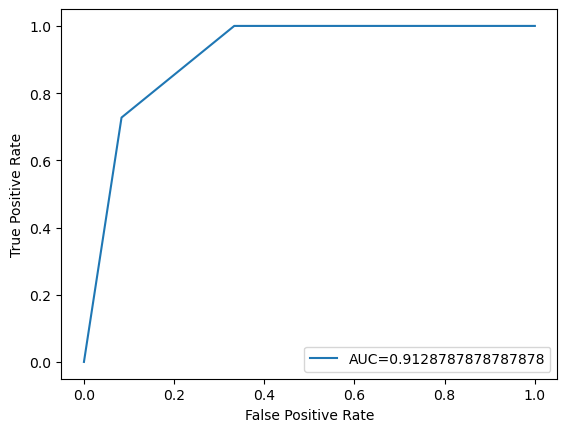


Total Execution Time: 00:00:00


In [31]:
start = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train_aug)
knn_pred = knn.predict(X_valid_scaled)
knn_proba = knn.predict_proba(X_valid_scaled)[::,1]
knn_acc, knn_loss = performance_metrics(knn_pred, model_type = "K-Nearest Neighbours")

plot_roc_auc(knn_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Not surprisingly, the base model doesn't perform well. With a validation accuracy of 60.87% and precision of 55.00%, this model will not be considered when tuning. The ROC curve has a slight arc with an area of 0.912. 

## Decision Trees

For Decision Trees, we expect an average performance, with Random Forests being the better model. Decision Trees often don’t perform well on small datasets, which ours is. It works on both linear and non-linear problems, but overfitting is a concern.

Validation Scores
Decision Tree
 Accuracy:  69.57%
 Log Loss:  1051.20%
 Precision: 64.29%
 Recall:    81.82%
 F1:        72.00%
 ROC-AUC:   70.08%


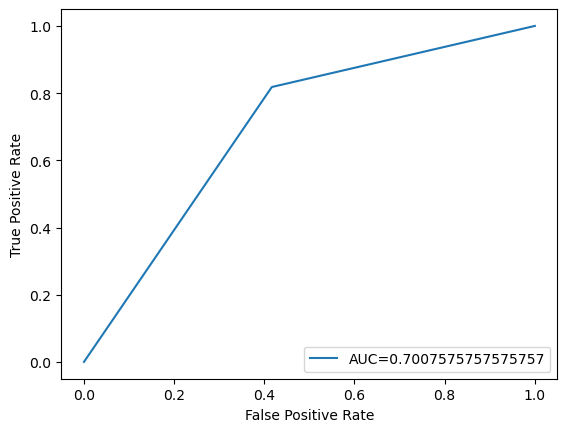


Total Execution Time: 00:00:06


In [32]:
start = time.time()

dt = DecisionTreeClassifier(random_state = random_state)
dt.fit(X_train_scaled, y_train_aug)
dt_pred = dt.predict(X_valid_scaled)
dt_proba = dt.predict_proba(X_valid_scaled)[::,1]
dt_acc, dt_loss = performance_metrics(dt_pred, model_type = "Decision Tree")

plot_roc_auc(dt_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

The base model does in fact, perform on average; better than Naive Bayes and KNN, but not as good as Logistic Regression and SVM. It has a validation accuracy of 86.96%, precision of 83.33%, recall of 90.91% and F1-score of 86.96%; all very high values. The ROC curve is decent, with an area of 0.871. There is still room for improvement in hyperparameter tuning. 

## Random Forest

We expect the base Random Forest to do well. It is an ensemble method meaning that it combines multiple Decision Tree models together to produce an even better one. We expect hyperparameter tuning will be important, and will need to pay attention to overfitting. 

Validation Scores
Random Forest
 Accuracy:  95.65%
 Log Loss:  150.17%
 Precision: 91.67%
 Recall:    100.00%
 F1:        95.65%
 ROC-AUC:   95.83%


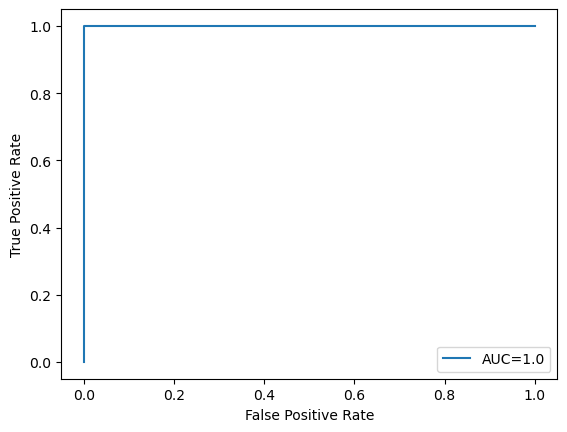


Total Execution Time: 00:00:01


In [33]:
start = time.time()

rf = RandomForestClassifier(random_state = random_state)
rf.fit(X_train_scaled, y_train_aug)
rf_pred = rf.predict(X_valid_scaled)
rf_proba = rf.predict_proba(X_valid_scaled)[::,1]
rf_acc, rf_loss = performance_metrics(rf_pred, model_type = "Random Forest")

plot_roc_auc(rf_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Our Random Forest does perform better than our Decision Tree. Its validation accuracy is high at 95.65%, with all other values above 90%. It is our second model with a perfect area under the ROC curve. We look forward to seeing how this model is impacted with hyperparameter tuning.

## Base Model Summary

Below is a table that summarizes the accuracies and log losses of our base models.

In [34]:
accuracies = [log_reg_acc, gnb_acc, svm_acc, knn_acc, dt_acc, rf_acc]
losses = [log_reg_loss, gnb_loss, svm_loss, knn_loss, dt_loss, rf_loss]
model_names = ["Logistic Regression", "Naive Bayes", "SVM", "KNN", "Decision Tree", "Random Forest"]
display_accuracies(accuracies, losses, model_names)

,Accuracy,Log Loss
Random Forest,95.65%,150.17%
SVM,91.30%,300.34%
Logistic Regression,78.26%,750.86%
Naive Bayes,73.91%,901.03%
Decision Tree,69.57%,1051.20%
KNN,60.87%,1351.55%


# Fine-Tuned Models   

As we said earlier, for our model to be considered effective, it needs to have a minimum accuracy of 90%. We had high hopes for our Logistic Regressoin model, so we will consider it an exception and tune it anyways. Thus, we will fine-tune the following models to see if we can further increase their already high accuracy. 
 - Logistic Regression
 - Random Forest
 - Support Vector Machine (SVM)

We will also construct a Convolutional Neural Network. 

For cross validation, we are using the `RepeatedStratifiedKFold` function with two splits since we have two classes (dark chocolate and white chocolate).

In [35]:
cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 4, random_state = random_state)

## Logistic Regression

While the base model performed quite well, there is always room for improvement. To optimize its hyperparameters, we will implement a Grid Search. In our Grid Search, our scoring function is `accuracy` because that is our preferred performance metric. We perform our Grid Search on our validation data.

**NOTE:** since not all of the `solver`s and `penalty` types work together, there are some `nan` scores. Also, for some of the parameter combinations certain other parameters get ignored. To clean up the output we are specifying that warnings are ignored. 

In [36]:
warnings.filterwarnings('ignore')

param_grid = {'solver': ["lbfgs", "liblinear", "newton-cg"], 
              'penalty': ["l1", "l2", "none"], 
              'C': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 25, 50]}

log_grid_search = GridSearchCV(LogisticRegression(random_state = random_state), 
                               param_grid, cv = cv, scoring = 'accuracy', verbose = 3)

start = time.time()

log_grid_search.fit(X_train_scaled, y_train_aug)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)),"\n")

grid_search_results(log_grid_search)

Fitting 8 folds for each of 81 candidates, totalling 648 fits
[CV 1/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 2/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 3/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 4/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 5/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 6/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 7/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 8/8] END ...C=1e-05, penalty=l1, solver=lbfgs;, score=nan total time=   0.2s
[CV 1/8] END C=1e-05, penalty=l1, solver=liblinear;, score=0.500 total time=   0.8s
[CV 2/8] END C=1e-05, penalty=l1, solver=liblinear;, score=0.500 total time=   0.8s
[CV 3/8] END C=1e-05, penalty=l1, solver=liblinear;, score=0.500 total time=   0.9s
[CV 4/8] END C=1e-05, penalty=l1, solv

The best score / accuracy did improve from the base model (looking back at the training score for the 0.65 split in the big list of scores). Having the best solver be `liblinear` makes sense as it is often a good choice for small datasets. Now that we have a tuned model, we make a prediction on the validation data and print the results. Since the `GridSearchCV` re-fits the best model, we just have to call `.best_estimator_`. 

Validation Scores
Tuned Logistic Regression
 Accuracy:  91.30%
 Log Loss:  300.34%
 Precision: 84.62%
 Recall:    100.00%
 F1:        91.67%
 ROC-AUC:   91.67%


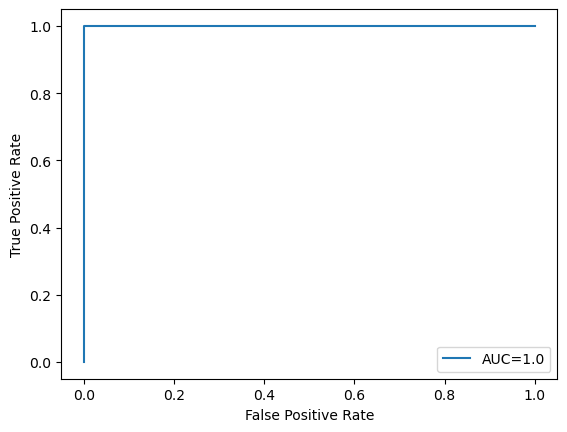


Total Execution Time: 00:00:00


In [37]:
start = time.time()

log_reg_tuned = log_grid_search.best_estimator_
log_reg_tuned_pred = log_reg_tuned.predict(X_valid_scaled)
log_reg_tuned_proba = log_reg_tuned.predict_proba(X_valid_scaled)[::,1]
log_reg_tuned_acc, log_reg_tuned_loss = performance_metrics(log_reg_tuned_pred, 
                                                            model_type = "Tuned Logistic Regression")

plot_roc_auc(log_reg_tuned_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Interestingly enough, we see huge improvement from the base model to our tuned model. The validation accuracy is at 91.30%, with precision at 84.62%, perfect recall, and an F1-score of 91.67%. It also produced a perfect area under the ROC curve.

## Random Forest

Our base Random Forest model already performed quite well so it'll be interesting to see how it improves with hyperparameter optimization. As we mentioned when training the base model, keeping an eye out for overfitting will be important here. 

In [38]:
param_grid = {'n_estimators': [10, 50, 100, 150, 400, 425, 450, 475, 500],
              'criterion': ["gini", "entropy", "log_loss"],
              'max_features': ["sqrt", "log2", 4, 5, 6],
              'bootstrap': [True, False]}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state = random_state),
                               param_grid, cv = cv, scoring = 'accuracy', verbose = 3)

start = time.time()

rf_grid_search.fit(X_train_scaled, y_train_aug)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)),"\n")

grid_search_results(rf_grid_search)

Fitting 8 folds for each of 270 candidates, totalling 2160 fits
[CV 1/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.721 total time=   0.3s
[CV 2/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.709 total time=   0.3s
[CV 3/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.709 total time=   0.3s
[CV 4/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.756 total time=   0.3s
[CV 5/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.779 total time=   0.3s
[CV 6/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.733 total time=   0.3s
[CV 7/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.698 total time=   0.3s
[CV 8/8] END bootstrap=True, criterion=gini, max_features=sqrt, n_estimators=10;, score=0.814 total time=   0.3s
[CV 1/8] END bootstrap=True, cri

Our optimal forest will be quite large with 400 trees (`n_estimators`). We aren't bootstrapping so we'll use the whole dataset for each tree, which makes sense since our dataset is small to begin with. Taking the _log2_ for `max_features` also makes sense as our dataset is of a very high dimension. 

Now that we have a tuned model, we make a prediction on the validation data and print the results. Since the `GridSearchCV` re-fits the best model we just have to call `.best_estimator_`. 

Validation Scores
Tuned Random Forest
 Accuracy:  86.96%
 Log Loss:  450.51%
 Precision: 83.33%
 Recall:    90.91%
 F1:        86.96%
 ROC-AUC:   87.12%


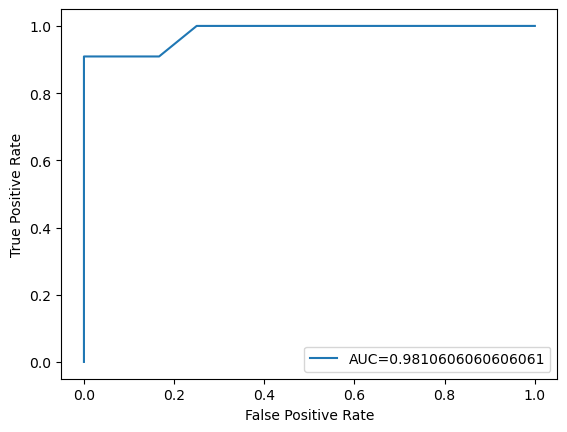


Total Execution Time: 00:00:00


In [39]:
start = time.time()

rf_tuned = rf_grid_search.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_valid_scaled)
rf_tuned_proba = rf_tuned.predict_proba(X_valid_scaled)[::,1]
rf_tuned_acc, rf_tuned_loss = performance_metrics(rf_tuned_pred, model_type = "Tuned Random Forest")

plot_roc_auc(rf_tuned_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Our tuned Random Forest performs slightly worse than the base model, with a validation accuracy about 9% lower. Log loss is much higher, but precision, recall, F1-score, and the area under the ROC curve are all lower. An area of 0.981 is still quite impressive, when the base had a perfect area under the ROC curve. It doesn't perform as well as the tuned Logistic Regression model, so while it'll be one of our top models, it won't be the best model.

## Support Vector Machines (SVM)

Originally, we were going to use a Grid Search to perform hyperparameter optimization for our SVM. However, it took an extremely long time to run. After trying a Randomized Search, we saw that we could get the same results as the Grid Search in a lot less time. Our only concern is the potential to overfit, so choosing an appropriate kernel and regularization term is important.

In [40]:
param_grid = {'C': [0.1, 0.5, 0.8, 1.0, 1.5, 2.0, 5.0, 10.0, 100.0],
              'kernel': ["linear", "poly", "rbf", "sigmoid"],
              'degree': [1, 2, 3, 4, 5, 10],
              'gamma': ["scale", "auto"],
              'shrinking': [True, False]}

svc_rand_search = RandomizedSearchCV(SVC(probability = True, random_state = random_state), 
                                     param_grid, cv = cv, scoring = 'accuracy',
                                     random_state = random_state, verbose = 3)

start = time.time()

svc_rand_search.fit(X_train_scaled, y_train_aug)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)),"\n")

grid_search_results(svc_rand_search)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.721 total time=   2.1s
[CV 2/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.767 total time=   2.4s
[CV 3/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.767 total time=   2.3s
[CV 4/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.733 total time=   1.6s
[CV 5/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.709 total time=   1.6s
[CV 6/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.744 total time=   1.4s
[CV 7/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.663 total time=   1.7s
[CV 8/8] END C=0.5, degree=10, gamma=auto, kernel=linear, shrinking=False;, score=0.733 total time=   1.7s
[CV 1/8] END C=2.0, degree=3, gamma=auto, kernel=linear, shrinking=True;, score=0.7

Our main concern was overfitting. The best value for `C`, our penalty parameter, is 0.5 which should still classify the data points correctly without overfitting. The `sigmoid` kernel makes sense as it is similar to the `sigmoid` function in Logistic Regression where it models the probability, and our dataset is binary. The `gamma` value is the same as the default model.

Now that we have a tuned model, we make a prediction on the validation data and print the results. Since the `RandomizedSearchCV` re-fits the best model we just have to call `.best_estimator_`.

Validation Scores
Tuned SVM
 Accuracy:  82.61%
 Log Loss:  600.69%
 Precision: 73.33%
 Recall:    100.00%
 F1:        84.62%
 ROC-AUC:   83.33%


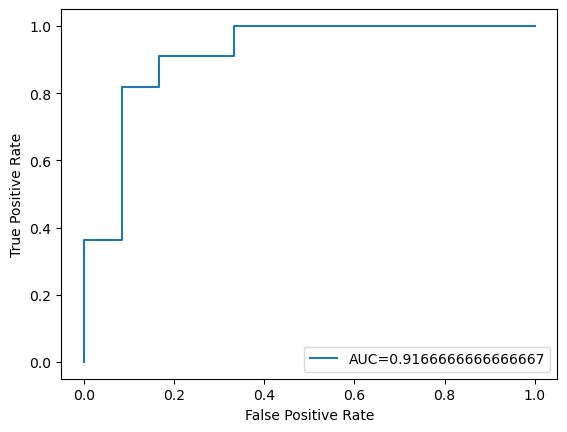


Total Execution Time: 00:00:00


In [41]:
start = time.time()

svm_tuned = svc_rand_search.best_estimator_
svm_tuned_pred = svm_tuned.predict(X_valid_scaled)
svm_tuned_proba = svm_tuned.predict_proba(X_valid_scaled)[::,1]
svm_tuned_acc, svm_tuned_loss = performance_metrics(svm_tuned_pred, model_type = "Tuned SVM")

plot_roc_auc(svm_tuned_proba)

print("\nTotal Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Our tuned SVM model doesn't perform as well as the base model, with a validation accuracy of 82.61% - almost 10% lower than the base. The precision is lower at 73.3%, however the recall is also at 100%. The area under our ROC curve is still quite high, at 0.916. 

## Convolutional Neural Networks (CNN)
The following model uses two convolutional layers, followed by one pooling layer, then a flatten layer, then a dropout layer with 25%, then a dense layer, another dropout layer with 50%, and finally the output layer which is a single neuron. In the first convolutional layer, we also include the size of the input. Since we're doing binary classification, we are using the `sigmoid` activation function in the output layer.

In [42]:
keras.backend.clear_session()
tf.random.set_seed(random_state)
np.random.seed(random_state)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, padding = "same", activation='relu', input_shape=(256, 256, 3)),
    keras.layers.Conv2D(64, kernel_size = 3, padding = "same", activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')  
])

2022-12-11 12:15:54.760072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can see the structure of our neural network below:

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dropout (Dropout)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                        

Now that our model is created, we can compile it so it's ready to use. Since we're doing binary classification, we use *binary_crossentropy* as our loss function, and we are most interested in the accuracy of our model. The *adam* optimizer is a replacement optimization algorithm for stochastic gradient descent used when training deep learning models.

In [44]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics = ['accuracy'])

Our model will augment our training data as it is being fit. To start, we will use a training batch size of 32, a validation batch size of 8, and 10 epochs.

In [45]:
start = time.time()
history = model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                    validation_data = datagen.flow(X_valid, y_valid, batch_size = 8),
                    steps_per_epoch = len(X_train) / 32, epochs = 10)
end = time.time()
print("The time of execution to fit our Convolutional Neural Network is :", (end-start), "seconds")

Epoch 1/10
2/2 [==============================] - 11s 3s/step - loss: 6936.2349 - accuracy: 0.4767 - val_loss: 6507.4551 - val_accuracy: 0.4783
Epoch 2/10
2/2 [==============================] - 8s 3s/step - loss: 4973.0005 - accuracy: 0.5349 - val_loss: 551.7057 - val_accuracy: 0.5217
Epoch 3/10
2/2 [==============================] - 7s 3s/step - loss: 1906.0774 - accuracy: 0.4651 - val_loss: 674.5781 - val_accuracy: 0.5217
Epoch 4/10
2/2 [==============================] - 7s 3s/step - loss: 418.0963 - accuracy: 0.5581 - val_loss: 92.8439 - val_accuracy: 0.4783
Epoch 5/10
2/2 [==============================] - 7s 3s/step - loss: 149.7794 - accuracy: 0.5465 - val_loss: 36.3642 - val_accuracy: 0.4783
Epoch 6/10
2/2 [==============================] - 7s 3s/step - loss: 49.0750 - accuracy: 0.4651 - val_loss: 24.4966 - val_accuracy: 0.5217
Epoch 7/10
2/2 [==============================] - 7s 3s/step - loss: 17.8466 - accuracy: 0.5000 - val_loss: 11.6489 - val_accuracy: 0.4783
Epoch 8/10
2/2

To see how well our model performed, we can look at its accuracy and loss in training and validation.

In [46]:
loss = history.history['loss'][9]
accuracy = history.history['accuracy'][9]
loss_v = history.history['val_loss'][9]
accuracy_v = history.history['val_accuracy'][9]
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.695652  ;  loss = 0.820921
Test: accuracy = 0.697674  ;  loss = 1.205292


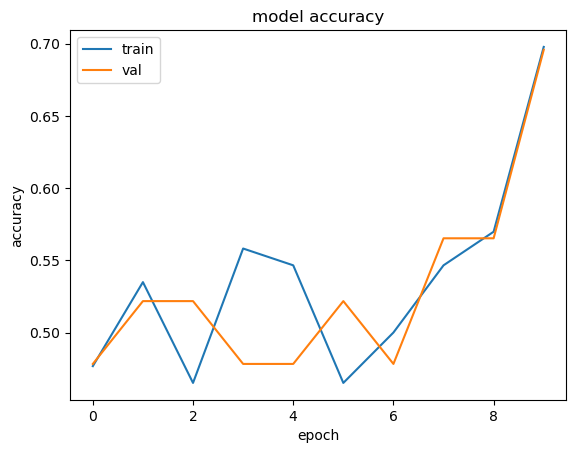

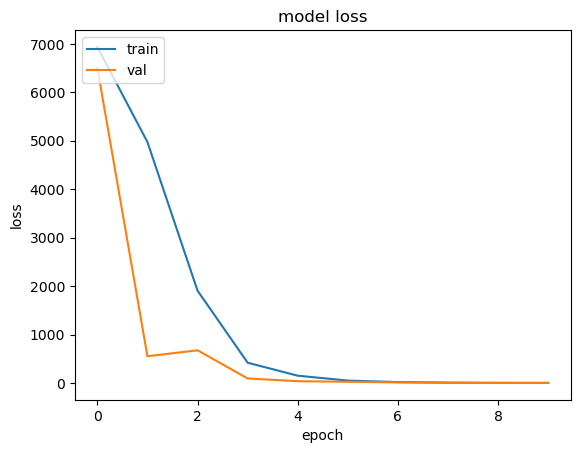

In [47]:
plot_model_metrics(history)

With a validation accuracy of 69.5% and a test accuracy of 69.7%, we know our model can be improved. 

Our first adjustment will be to change the training batch size to 24 and the validation batch size to 16.

In [48]:
start = time.time()
history1 = model.fit(datagen.flow(X_train, y_train, batch_size = 24),
                    validation_data = datagen.flow(X_valid, y_valid, batch_size = 16),
                    steps_per_epoch = len(X_train) / 24, epochs = 10)
end = time.time()
print("The time of execution to fit our Convolutional Neural Network is :", (end-start), "seconds")

Epoch 1/10
3/3 [==============================] - 7s 2s/step - loss: 1.1528 - accuracy: 0.6279 - val_loss: 0.7644 - val_accuracy: 0.4783
Epoch 2/10
3/3 [==============================] - 8s 2s/step - loss: 0.8594 - accuracy: 0.6744 - val_loss: 0.9378 - val_accuracy: 0.7826
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.6365 - accuracy: 0.7326 - val_loss: 0.9126 - val_accuracy: 0.6957
Epoch 4/10
3/3 [==============================] - 8s 3s/step - loss: 0.6171 - accuracy: 0.6977 - val_loss: 0.9418 - val_accuracy: 0.6957
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 0.5889 - accuracy: 0.7442 - val_loss: 0.6286 - val_accuracy: 0.7391
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 0.5178 - accuracy: 0.7674 - val_loss: 0.8953 - val_accuracy: 0.6087
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0.8609 - accuracy: 0.6744 - val_loss: 0.7818 - val_accuracy: 0.5217
Epoch 8/10
3/3 [=========================

In [49]:
loss1 = history1.history['loss'][9]
accuracy1 = history1.history['accuracy'][9]
loss_v1 = history1.history['val_loss'][9]
accuracy_v1 = history1.history['val_accuracy'][9]
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v1, loss_v1))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy1, loss1))

Validation: accuracy = 0.608696  ;  loss = 1.301469
Test: accuracy = 0.755814  ;  loss = 0.754756


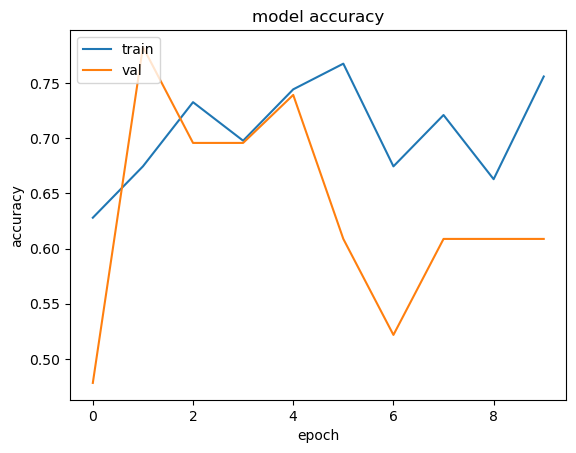

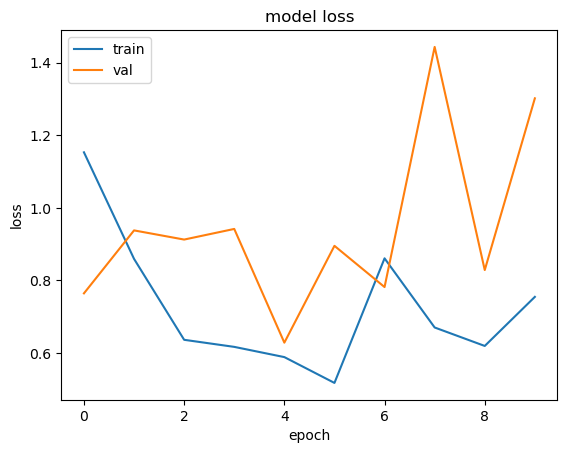

In [50]:
plot_model_metrics(history1)

Our validation accuracy decreased to 60.8% and our test accuracy increased to 75.5%. Still not the greatest result, so we'll adjust the batch sizes again. 

The training batch size will be 16 and the validation batch size will be 8.

In [51]:
start = time.time()
history2 = model.fit(datagen.flow(X_train, y_train, batch_size = 16),
                    validation_data = datagen.flow(X_valid, y_valid, batch_size = 8),
                    steps_per_epoch = len(X_train) / 16, epochs = 10)
end = time.time()
print("The time of execution to fit our Convolutional Neural Network is :", (end-start), "seconds")

Epoch 1/10
5/5 [==============================] - 8s 2s/step - loss: 0.6281 - accuracy: 0.6512 - val_loss: 0.8088 - val_accuracy: 0.7826
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 0.7409 - accuracy: 0.7558 - val_loss: 0.7508 - val_accuracy: 0.6957
Epoch 3/10
5/5 [==============================] - 8s 1s/step - loss: 0.6419 - accuracy: 0.7442 - val_loss: 0.7685 - val_accuracy: 0.6522
Epoch 4/10
5/5 [==============================] - 8s 2s/step - loss: 0.8246 - accuracy: 0.6628 - val_loss: 0.7729 - val_accuracy: 0.5217
Epoch 5/10
5/5 [==============================] - 8s 1s/step - loss: 0.6669 - accuracy: 0.6744 - val_loss: 1.1757 - val_accuracy: 0.5652
Epoch 6/10
5/5 [==============================] - 8s 1s/step - loss: 0.7385 - accuracy: 0.6047 - val_loss: 0.7694 - val_accuracy: 0.6522
Epoch 7/10
5/5 [==============================] - 8s 1s/step - loss: 0.6957 - accuracy: 0.6744 - val_loss: 1.0577 - val_accuracy: 0.5217
Epoch 8/10
5/5 [=========================

In [52]:
loss2 = history2.history['loss'][9]
accuracy2 = history2.history['accuracy'][9]
loss_v2 = history2.history['val_loss'][9]
accuracy_v2 = history2.history['val_accuracy'][9]
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v2, loss_v2))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy2, loss2))

Validation: accuracy = 0.608696  ;  loss = 0.642006
Test: accuracy = 0.709302  ;  loss = 0.576294


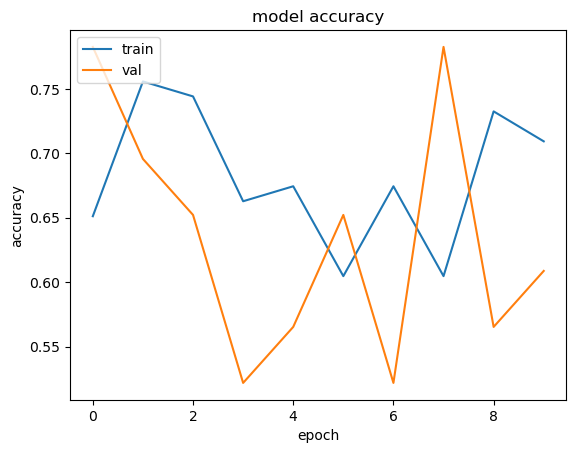

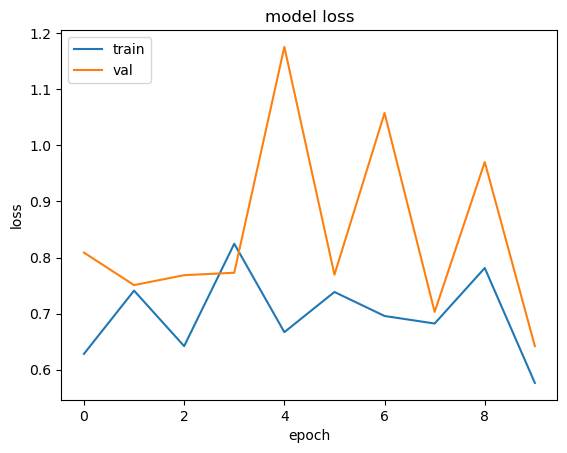

In [53]:
plot_model_metrics(history2)

Our validation accuracy stayed the same at 60.8% and our test accuracy slightly decreased to 70.9%. We'll try one more adjustment to the batch sizes.

The training batch size will be 8 and the validation batch size will be 4.

In [54]:
start = time.time()
history3 = model.fit(datagen.flow(X_train, y_train, batch_size = 8),
                    validation_data = datagen.flow(X_valid, y_valid, batch_size = 4),
                    steps_per_epoch = len(X_train) / 8, epochs = 10)
end = time.time()
print("The time of execution to fit our Convolutional Neural Network is :", (end-start), "seconds")

Epoch 1/10
10/10 [==============================] - 10s 919ms/step - loss: 0.9747 - accuracy: 0.6279 - val_loss: 0.8251 - val_accuracy: 0.5652
Epoch 2/10
10/10 [==============================] - 9s 857ms/step - loss: 0.9022 - accuracy: 0.6047 - val_loss: 0.7502 - val_accuracy: 0.6522
Epoch 3/10
10/10 [==============================] - 9s 862ms/step - loss: 0.6778 - accuracy: 0.6860 - val_loss: 0.8186 - val_accuracy: 0.5652
Epoch 4/10
10/10 [==============================] - 9s 843ms/step - loss: 0.5501 - accuracy: 0.7907 - val_loss: 0.9201 - val_accuracy: 0.6957
Epoch 5/10
10/10 [==============================] - 9s 859ms/step - loss: 0.9713 - accuracy: 0.6512 - val_loss: 0.8192 - val_accuracy: 0.6087
Epoch 6/10
10/10 [==============================] - 10s 866ms/step - loss: 0.7060 - accuracy: 0.6744 - val_loss: 0.6546 - val_accuracy: 0.5217
Epoch 7/10
10/10 [==============================] - 9s 845ms/step - loss: 0.6376 - accuracy: 0.6279 - val_loss: 1.0703 - val_accuracy: 0.5652
Epoc

In [55]:
loss3 = history3.history['loss'][9]
accuracy3 = history3.history['accuracy'][9]
loss_v3 = history3.history['val_loss'][9]
accuracy_v3 = history3.history['val_accuracy'][9]
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v3, loss_v3))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy3, loss3))

Validation: accuracy = 0.521739  ;  loss = 1.610750
Test: accuracy = 0.744186  ;  loss = 0.743662


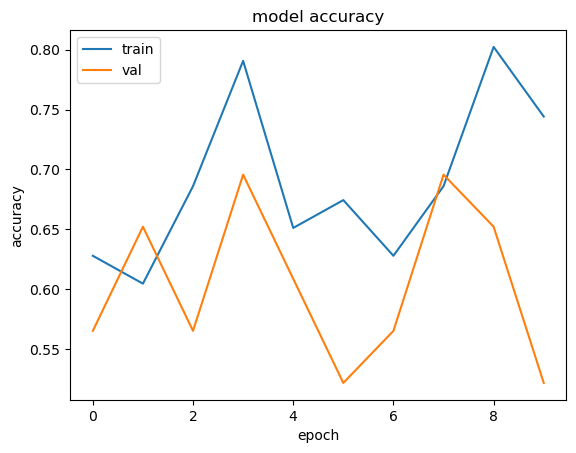

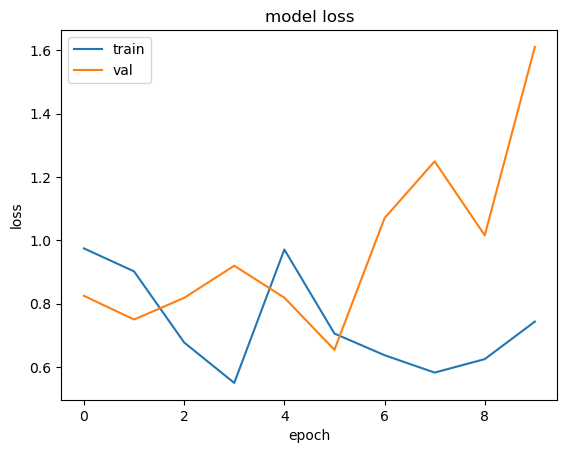

In [56]:
plot_model_metrics(history3)

Our validation accuracy decreased to 52.1% and our test accuracy increased to 74.4%, which are our best results for testing. We'll set these values to our CNN variables.

In [57]:
cnn_val_acc = accuracy_v3
cnn_val_loss = loss_v3

## Tuned Model Summary

Below is a table that summarizes the accuracies and log losses of both the base models and the hyperparameter tuned ones. 

In [59]:
tuned_accuracies = [log_reg_tuned_acc, svm_tuned_acc, rf_tuned_acc, cnn_val_acc]
tuned_losses = [log_reg_tuned_loss, svm_tuned_loss, rf_tuned_loss, cnn_val_loss]
tuned_model_names = ["Tuned Logistic Regression", "Tuned SVM", "Tuned Random Forest", "CNN"]
all_accuracies = accuracies + tuned_accuracies
all_losses = losses + tuned_losses
all_model_names = model_names + tuned_model_names
display_accuracies(all_accuracies, all_losses, all_model_names)

,Accuracy,Log Loss
Random Forest,95.65%,150.17%
SVM,91.30%,300.34%
Tuned Logistic Regression,91.30%,300.34%
Tuned Random Forest,86.96%,450.51%
Tuned SVM,82.61%,600.69%
Logistic Regression,78.26%,750.86%
Naive Bayes,73.91%,901.03%
Decision Tree,69.57%,1051.20%
KNN,60.87%,1351.55%
CNN,52.17%,161.08%


It is interesting to note that, as the accuracy increases, the log loss decreases, with the exception of our Convolutional Neural Network (CNN), where as the accuracy decreases, so does the log loss.

For our CNN, with a low accuracy and low log loss, that means we made little errors on a lot of data. Either our CNN needs a lot more improvement, or it just isn't the right fit for our dataset (could be too complicated).

# Final Evaluation

To determine our best model, we will take each model that has an accuracy of at least 90% and see how they perform on our test data. This includes:
 - Logistic Regression (base and tuned)
 - Random Forest (base and tuned)
 - Support Vector Machine (SVM) (base and tuned)
 
Thus, we will have six models to review after testing.

## Logistic Regression

In [60]:
log1_test = log_reg.predict(X_test_scaled)
log1_test_acc, log1_test_loss = performance_metrics(log1_test, "Logistic Regression", validation = False)

Test Scores
Logistic Regression
 Accuracy:  83.33%
 Log Loss:  575.65%
 Precision: 83.33%
 Recall:    83.33%
 F1:        83.33%
 ROC-AUC:   83.33%


As we suspected earlier, this model doesn't perform overly well on the test data, and most likely won't be our best model.

## Random Forest 

In [61]:
rf_test = rf.predict(X_test_scaled)
rf_test_acc, rf_test_loss = performance_metrics(rf_test, "Random Forest", validation = False)

Test Scores
Random Forest
 Accuracy:  87.50%
 Log Loss:  431.74%
 Precision: 90.91%
 Recall:    83.33%
 F1:        86.96%
 ROC-AUC:   87.50%


As expected, this model performs very well on our test data. It will definitely be one of our best models.

## Tuned Logistic Regression

In [62]:
log2_test = log_reg_tuned.predict(X_test_scaled)
log2_test_acc, log2_test_loss = performance_metrics(log2_test, "Tuned Logistic Regression", validation = False)

Test Scores
Tuned Logistic Regression
 Accuracy:  95.83%
 Log Loss:  143.91%
 Precision: 100.00%
 Recall:    91.67%
 F1:        95.65%
 ROC-AUC:   95.83%


While the tuned Logistic Regression model performed better on the test data than the base model, it didn't perform as well as our Random Forest. Thus, it will not be among our best models.

## Tuned Random Forest

In [63]:
rf2_test = rf_tuned.predict(X_test_scaled)
rf2_test_acc, rf2_test_loss = performance_metrics(rf2_test, "Tuned Random Forest", validation = False)

Test Scores
Tuned Random Forest
 Accuracy:  87.50%
 Log Loss:  431.74%
 Precision: 90.91%
 Recall:    83.33%
 F1:        86.96%
 ROC-AUC:   87.50%


The tuned Random Forest model performed worse than the base model on the test data, and so, it will not be considered for our best model. 

## Support Vector Machine (SVM)

In [64]:
svm1_test = svm.predict(X_test_scaled)
svm1_test_acc, svm1_test_loss = performance_metrics(svm1_test, "SVM", validation = False)

Test Scores
SVM
 Accuracy:  91.67%
 Log Loss:  287.83%
 Precision: 91.67%
 Recall:    91.67%
 F1:        91.67%
 ROC-AUC:   91.67%


Even though we were unsure of its overall performance, this model performs exceptionally well on our test data. It has currently taken the spot of being our best model.

## Tuned Support Vector Machine (SVM)

In [65]:
svm2_test = svm_tuned.predict(X_test_scaled)
svm2_test_acc, svm2_test_loss = performance_metrics(svm2_test, "Tuned SVM", validation = False)

Test Scores
Tuned SVM
 Accuracy:  66.67%
 Log Loss:  1151.32%
 Precision: 61.11%
 Recall:    91.67%
 F1:        73.33%
 ROC-AUC:   66.67%


Since the tuned Support Vector Machine performed worse on the test data than the base model, it will not be our best model.

### Summary 

Below is a table that summarizes the above testing results.

In [66]:
test_accuracies = [log1_test_acc, rf_test_acc, log2_test_acc, rf2_test_acc, svm1_test_acc, svm2_test_acc]
test_losses = [log1_test_loss, rf_test_loss, log2_test_loss, rf2_test_loss, svm1_test_loss, svm2_test_loss]
model_names = ["Logistic Regression", "Random Forest", "Tuned Logistic Regression", "Tuned Random Forest",
               "SVM", "Tuned SVM"]
display_accuracies(test_accuracies, test_losses, model_names)

,Accuracy,Log Loss
Tuned Logistic Regression,95.83%,143.91%
SVM,91.67%,287.83%
Random Forest,87.50%,431.74%
Tuned Random Forest,87.50%,431.74%
Logistic Regression,83.33%,575.65%
Tuned SVM,66.67%,1151.32%


# Best Model

As stated earlier, our best model will be the one that performs the best on our test data. According to the table above, our best model is our tuned Logistic Regression model with a test accuracy of 95.83%. However, we noticed that the base Support Vector Machine's (SVM) difference between training accuracy, validation accuracy, and testing accuracy is more consistent, it generalizes better. So, we declare that our best model is our base SVM with a testing accuracy of 91.67%. Below is a confusion matrix to show how well it classifies our pictures of chocolate.

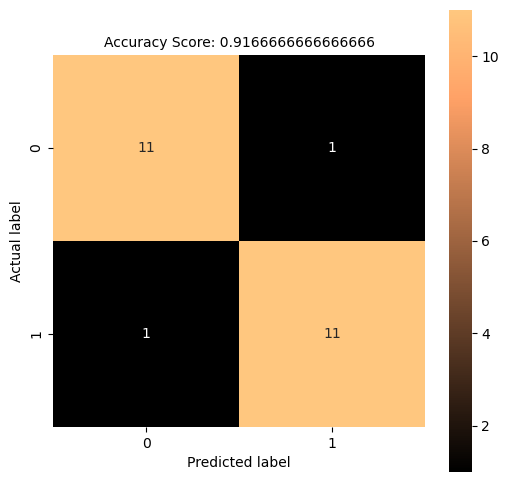

In [67]:
score = svm.score(X_test_scaled, y_test)

cm = metrics.confusion_matrix(y_test, svm1_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, square = True, cmap = sns.color_palette("copper", as_cmap=True));
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 10);

As we can see in the confusion matrix, our SVM model has a true positive value of 11, a true negative value of 11, a false positive value of one, and a false negative value of one. Considering our dataset is small, this model is extremely impressive at classifying our images of chocolate.

# Conclusion

Our best performing models were what we expected. Logistic Regression, Support Vector Machine, and Random Forest (both the base and tuned versions). These likely performed the best because they are good with small datasets, with datasets that have high dimensions, and datasets that are fairly linear. According to the [research](https://www.knowledgehut.com/blog/data-science/support-vector-machines-in-machine-learning), we know that Support Vector Machines are good for datasets that have more columns than rows (which ours does). What was most interesting was that the tuning version generalized worse than the base model. This could be because the images in our training set were not a good representation of the whole dataset.

However, even though our dataset was small with a high number of dimensions, we were still able to find a model that met our goal of a minimum of 90% accuracy to classify images of dark and white chocolate.

In [68]:
print("\nTotal Project Execution Time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))


Total Project Execution Time: 01:10:04
